<a href="https://colab.research.google.com/github/yatindma/Automated-Response-Suggestion-for-Email/blob/master/Smart_Gmail_Reply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Overview </h2>

Here we'll try to predict the Short email responses.<br>
As most of the emails have shorter reply.<br>
So that it can be easy to reply, without the hassle of typing.<br>
It can help in saving the time of the person.<br>

########################################################

Will update later.
########################################################


[my kilnkn](www.com)




In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
import tensorflow as tf
tf.keras.__version__

'2.2.4-tf'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [0]:
# !pip3 install keras-self-attention

# Attention Layer

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self,input, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    input = None
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weightst

# Reading the data

In [0]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json
arr = []
question = []
answer = []
with open("drive/My Drive/JSON_data/train_data.txt","rb") as json_file:
    data = json.load(json_file)
    for data_ in data['data']:
        for j,para in enumerate(data_['paragraphs']):
          for k,qas in enumerate(para['qas']):
            for ans in qas['answers']:
              answer.append(ans['text'])
              question.append(qas['question'])  
              break
        


In [0]:
df = pd.DataFrame(list(zip(question, answer)), 
               columns =['question', 'reply']) 

In [0]:
df.tail(3)

,question,reply
86818,With what Belorussian city does Kathmandu have...,Minsk
86819,In what year did Kathmandu create its initial ...,1975
86820,What is KMC an initialism of?,Kathmandu Metropolitan City


In [0]:
#Add more data to the above data 
df2 = pd.read_csv("drive/My Drive/JSON_data/qa_dataset.csv", encoding = "ISO-8859-1", low_memory=False)

In [0]:
df2.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Volta an Italian physicist?,yes,easy,easy,data/set4/a10
1,Alessandro_Volta,Is Volta buried in the city of Pittsburgh?,no,easy,easy,data/set4/a10


In [0]:
#Drop the columns which we don' need 
df2 = df2.drop(['ArticleTitle','DifficultyFromQuestioner','DifficultyFromAnswerer','ArticleFile'],axis =1 ) 
df2.columns = ['question', 'reply']

In [0]:
df3 = pd.read_csv("drive/My Drive/JSON_data/music_questions.csv")
df3.columns = ['q','question', 'reply']
df3.drop(['q'],axis = 1).head(2)

,question,reply
0,how long is this cord? the pictures looks like...,I took a photo: <http://imgur.com/G48f1C4>I bo...
1,Has anyone used this to split a stereo signal?...,I believe this adapter yields a mono split and...


In [0]:
df4 = pd.read_csv("drive/My Drive/JSON_data/grocery_questions.csv")
df4.columns = ['q','question', 'reply']
df4.drop(['q'],axis = 1).head(2)

,question,reply
0,what are the colors that come in the package?,"All colors seen on box plus Teal, Burgundy, Bl..."
1,difference between meat cure and pickling salt,Pickling salt is a very pure form of salt. A m...


In [0]:
df5 = pd.read_csv("drive/My Drive/JSON_data/video_game_qa.csv")
df5.columns = ['q','question', 'reply']
df5.drop(['q'],axis = 1).head(2)

,question,reply
0,"Yes, you will need to go to their website to d...","Yes, you will need to go to their website to d..."
1,As long as it has a USB port it should work fi...,As long as it has a USB port it should work fi...


In [0]:
df2.shape

(2917, 2)

In [0]:
df.shape

(86821, 2)

In [0]:
df3.shape

(2976, 3)

In [0]:
df4.shape

(2997, 3)

In [0]:
df5.shape

(1183, 3)

In [0]:
#Append both the dataset

frames = [df, df2,df3,df4,df5]
data = pd.concat(frames)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# data = pd.read_csv('qa_dataset.csv', encoding = "ISO-8859-1", low_memory=False) 

In [0]:
# data.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Volta an Italian physicist?,yes,easy,easy,data/set4/a10
1,Alessandro_Volta,Is Volta buried in the city of Pittsburgh?,no,easy,easy,data/set4/a10


In [0]:
# data = data.drop(['ArticleTitle','DifficultyFromQuestioner','DifficultyFromAnswerer','ArticleFile'],axis = 1)

In [0]:
# data.columns = ['question','reply']

In [0]:
# Columns
# Description of the data frame
print("="*25 + " Data Overview " + "="*25)
print("\n", data.info(), "\n")
print("="*25 + " Sample Data " + "="*25)
print(data.head(5))

========================= Data Overview =========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 2 columns):
question    2917 non-null object
reply       2917 non-null object
dtypes: object(2)
memory usage: 45.7+ KB

 None 

========================= Sample Data =========================
                                            question           reply
0                    Was Volta an Italian physicist?             yes
1         Is Volta buried in the city of Pittsburgh?              no
2  Did Volta have a passion for the study of elec...             yes
3  What is the battery made by Volta credited to be?  the first cell
4  What important electrical unit was named in ho...        the volt


### Preprocessing

In [0]:
# Convert data into lower case
data = data.apply(lambda x: x.astype(str).str.lower())
data.head(4)

,question,reply
0,was volta an italian physicist?,yes
1,is volta buried in the city of pittsburgh?,no
2,did volta have a passion for the study of elec...,yes
3,what is the battery made by volta credited to be?,the first cell


In [0]:
data.head()

,question,reply
0,was volta an italian physicist?,yes
1,is volta buried in the city of pittsburgh?,no
2,did volta have a passion for the study of elec...,yes
3,what is the battery made by volta credited to be?,the first cell
4,what important electrical unit was named in ho...,the volt


In [0]:
#counting length of each sentence in target 
sentences = data['reply'].values
len_arr = []
for sent in sentences:
  count = 0
  for words in sent:
    count += 1
  len_arr.append(count)
  


In [0]:
data['reply_length'] = len_arr

In [0]:
#Calculating average length of th target sentences
avg_length = sum(len_arr)/len(len_arr)
print('average length',avg_length)

average length 25.082961947206034


In [0]:
data.tail(2)

,question,reply,reply_length
2915,"was wilson , a staunch opponent of antisemitis...",yes,3
2916,what happened in 1917?,"raised billions through liberty loans, imposed...",259


In [0]:
# Remove the full stops from the dataframe reply
bad_chars = [';', ':', '!', "*",'.',')','(','?']
preprocessed_reply = []

for reply in data['reply'].values:
  for i in bad_chars : 
    reply = reply.replace(i, '')
  preprocessed_reply.append(reply)

data['reply'] = preprocessed_reply
data['reply'] = 'start_ ' + data['reply'] + ' _end'

In [0]:
# trim the string the dataframe  
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [0]:
data.head(2)

,question,reply,reply_length
0,was volta an italian physicist?,start_ yes _end,3
1,is volta buried in the city of pittsburgh?,start_ no _end,2


In [0]:
reply_list = list(data['reply'].values)
reply_dict = {i:reply_list.count(i) for i in reply_list}

In [0]:
from collections import OrderedDict
reply_dict_sorted = OrderedDict(sorted(reply_dict.items(), key=lambda x: x[1]))

In [0]:
reply = []
keys = []
for item in reply_dict_sorted.items():
  reply.append(item[0])
  keys.append(item[1])

In [0]:
reply.reverse()
keys.reverse()

In [0]:
#top 10 reply
top_5_reply = reply[:5]
top_5_keys = keys[:5]

In [0]:
temp_reply_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_reply_list.append(top_5_reply[i])
  i += 1

<b>
Article title can be used while giving the sentence for tokenizing later 
question do we need to preprocess the data
reply mai kitne repeated h
</b>


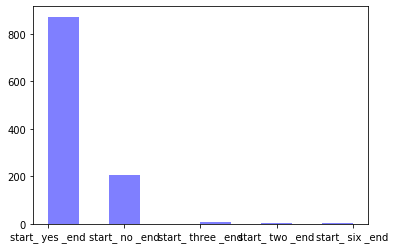

In [0]:
plt.hist(temp_reply_list, 10,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

From the above graph we can observe that 
<b>yes</b> and <b>no</b> reply are the most common reply in the mails which is making data very unbalanced and later will force model to predict mostly yes

To overcome above problem we need to remove some of the data which is having yes and no as response

In [0]:
#drop the yes/no response from 
temp_df_wo_yes = data[data['reply'] != 'start_ yes _end']
temp_df_wo_no_yes = temp_df_wo_yes[temp_df_wo_yes['reply'] != 'start_ no _end']


In [0]:
temp_df_w_yes = data[data['reply'] == 'start_ yes _end']
temp_df_w_no = data[data['reply'] == 'start_ no _end']

In [0]:
#calcuating data with yes and no replies
print('yes replies length',len(temp_df_w_yes))
print('no replies length',len(temp_df_w_no))

yes replies length 872
no replies length 206


In [0]:
#We'll taek only 100 responses with yes and 100 with no
yes_df = temp_df_w_yes[:100]
no_df = temp_df_w_no[:100]

In [0]:
#Appending 100 yes and 100 no replies data
temp_df_wo_no_yes.append(yes_df, ignore_index=True)
temp_df_wo_no_yes.append(no_df, ignore_index=True)
data = temp_df_wo_no_yes

In [0]:
data.head()

,question,reply,reply_length
3,what is the battery made by volta credited to be?,start_ the first cell _end,14
4,what important electrical unit was named in ho...,start_ the volt _end,8
5,what important electrical unit was named in ho...,start_ volt _end,4
6,where did volta enter retirement?,start_ spain _end,5
10,for how many years did alessandro volta live?,start_ 53 _end,2


number of email don' have any reply : 0
**************************************************
Max length : 932
**************************************************
Min Length : 12
**************************************************
Average Length : 49.566612289287654
**************************************************
No of unique reply : 168
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


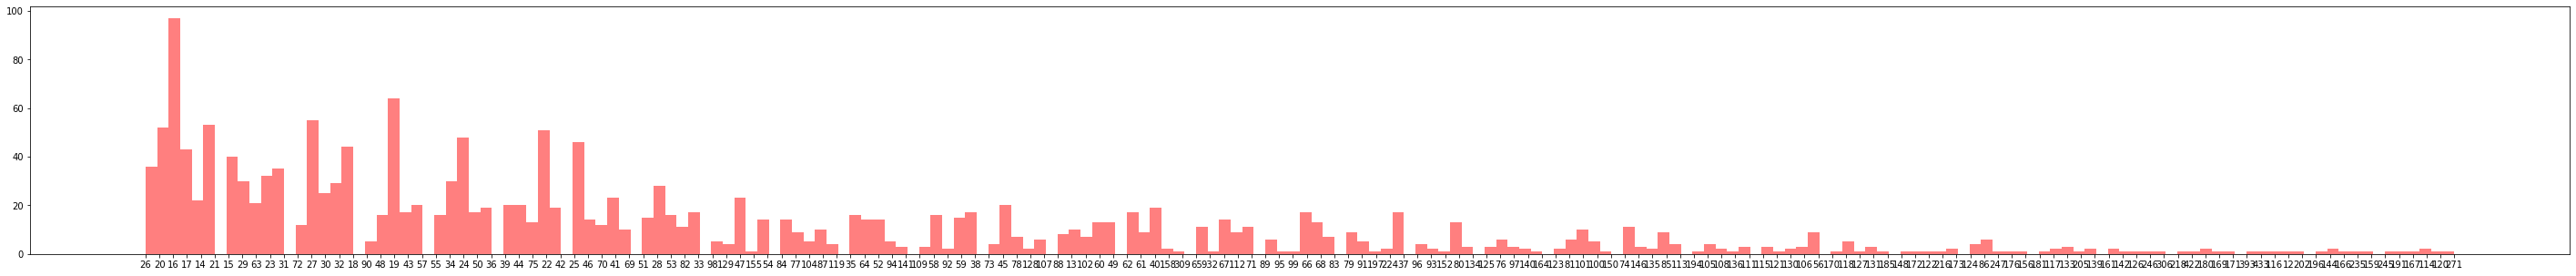

In [0]:
import matplotlib
matplotlib.rc('figure', figsize=[50,5])
#Getting the length of each reply
data["reply Length"]= data["reply"].str.len()
len_reply = data["reply Length"].values

#converting datatype to string
len_str_arr = []
for num in len_reply:
  len_str_arr.append(str(num)) 

no_reply_counter = 0
for num in len_reply:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_reply:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_reply)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_reply)))/(len(list(len_reply))))
print('*' * 50)

print("No of unique reply", end = ' : ')
print(len(list(set(len_reply))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

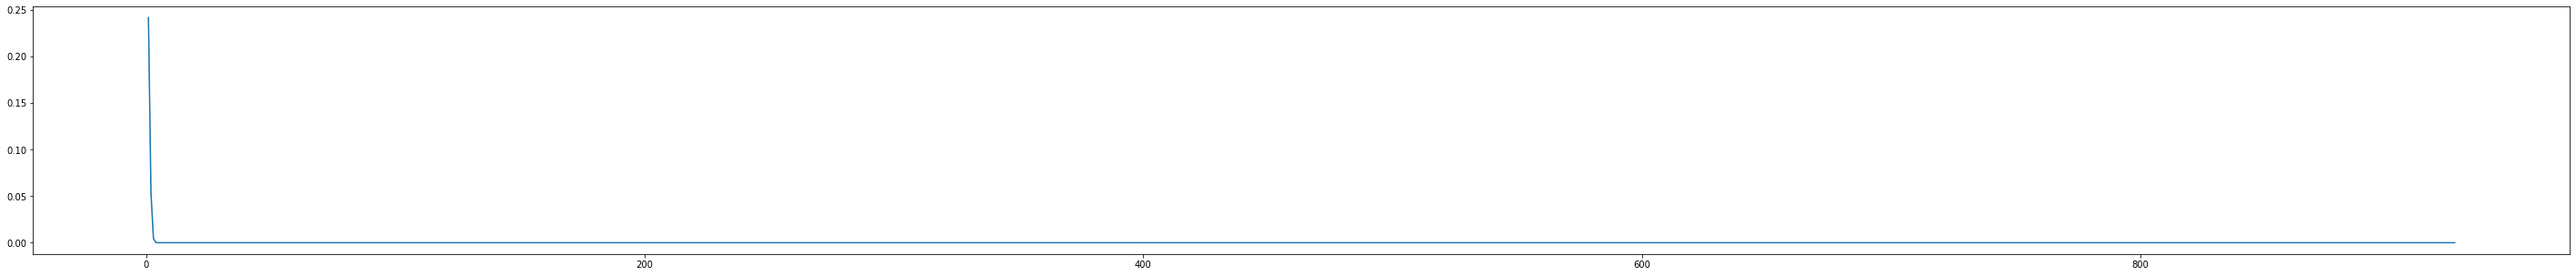

In [0]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

x = len_arr # generate samples from normal distribution (discrete data)
norm_cdf = scipy.stats.norm.pdf(x) # calculate the cdf - also discrete

# plot the cdf
sns.lineplot(x=x, y=norm_cdf)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


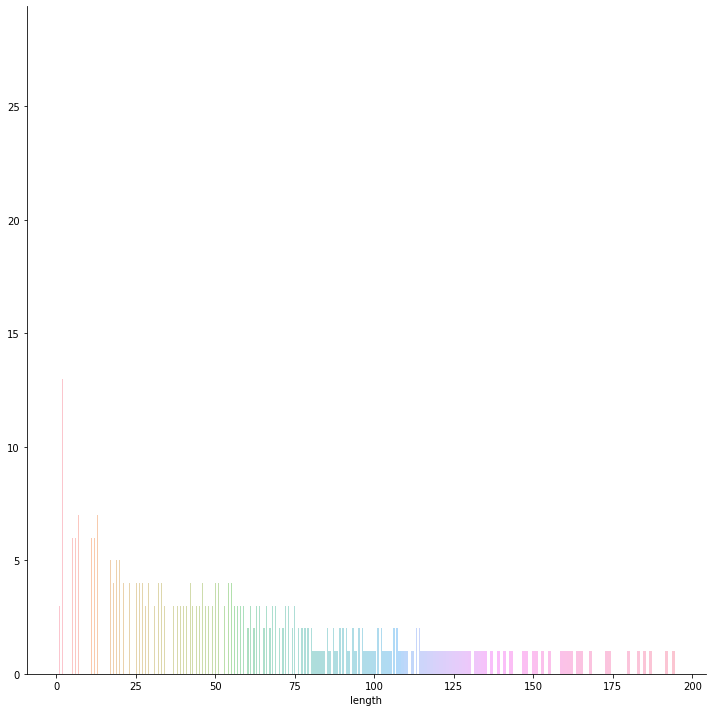

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
#lets zoom into it
copy_len_arr = (len_arr).copy()

copy_len_arr.sort()

#take only top 200
temp_len_arr = []
for len in copy_len_arr:
  if len > 200:
    break
  else:
    temp_len_arr.append(len)

temp_df = pd.DataFrame(temp_len_arr) 
temp_df.columns = ['length']

sns.FacetGrid(temp_df, hue="length", height=10).map(sns.distplot, "length")
plt.show();

<h3> From the above graph and average off all reply we'll take 20 as the maximum limit for a reply to exist </h3>

In [0]:
data.head(2)

,question,reply,reply_length,reply Length
3,what is the battery made by volta credited to be?,start_ the first cell _end,14,26
4,what important electrical unit was named in ho...,start_ the volt _end,8,20


In [0]:
data = data.sample(frac=1)

In [0]:
data.head()

,question,reply,reply_length,reply Length
1085,how is the climate in the city?,start_ the city is hot and humid _end,26,37
579,where is harvesting wild turtles legal?,start_ florida _end,7,19
2238,what expired on march?,start_ monroe's presidency _end,19,31
693,what are the three segments of an ant?,"start_ the head, mesosoma and metasoma are the...",69,80
2080,who is the head of state of ghana?,start_ john agyekum kufuor _end,19,31


From above graphs and data we observed that <b>maximun reply have less words. </b><br><br>
and <b>average length</b> if reply is nearly <b>25</b> words<br><br>
We have <b>169</b> unique reply


<h2> Check for emails </h2>

In [0]:
all_questions = data['question'].values

In [0]:
#Preprocessing questions 
#Remove the full stops from the dataframe replys

bad_chars = [';', ':', '!', "*",'.',')','(','?','-','--']

preprocessed_question = []
for question in all_questions:
  for i in bad_chars : 
    question = question.replace(i, '')
  preprocessed_question.append(question)



In [0]:
data['question'] = preprocessed_question

<h3> Words stemming </h3>

In [0]:
#We'll not use Word steemming here as it can create problem in understanding grammar.
# #Performing stammering here
# # We are having less data
# from nltk.stem import PorterStemmer
# porter = PorterStemmer()
# stemmed_sent = []
# for sent in preprocessed_question:
#   word_arr = []
#   for word in sent.split():
#     word_arr.append(porter.stem(word))
#   temp_str = ""
#   for words in word_arr:
#     temp_str += words + " "
#   stemmed_sent.append(temp_str)

In [0]:
# data['question'] = stemmed_sent

In [0]:
#trimming the string the dataframe  
#because after removal of the special character trimming might have lost
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [0]:
data.head()

,question,reply,reply_length,reply Length
1085,how is the climate in the city,start_ the city is hot and humid _end,26,37
579,where is harvesting wild turtles legal,start_ florida _end,7,19
2238,what expired on march,start_ monroe's presidency _end,19,31
693,what are the three segments of an ant,"start_ the head, mesosoma and metasoma are the...",69,80
2080,who is the head of state of ghana,start_ john agyekum kufuor _end,19,31


In [0]:
del len

number of email don' have any reply : 0
**************************************************
Max length : 246
**************************************************
Min Length : 4
**************************************************
Average Length : 48.07340946166395
**************************************************
No of unique reply : 119
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


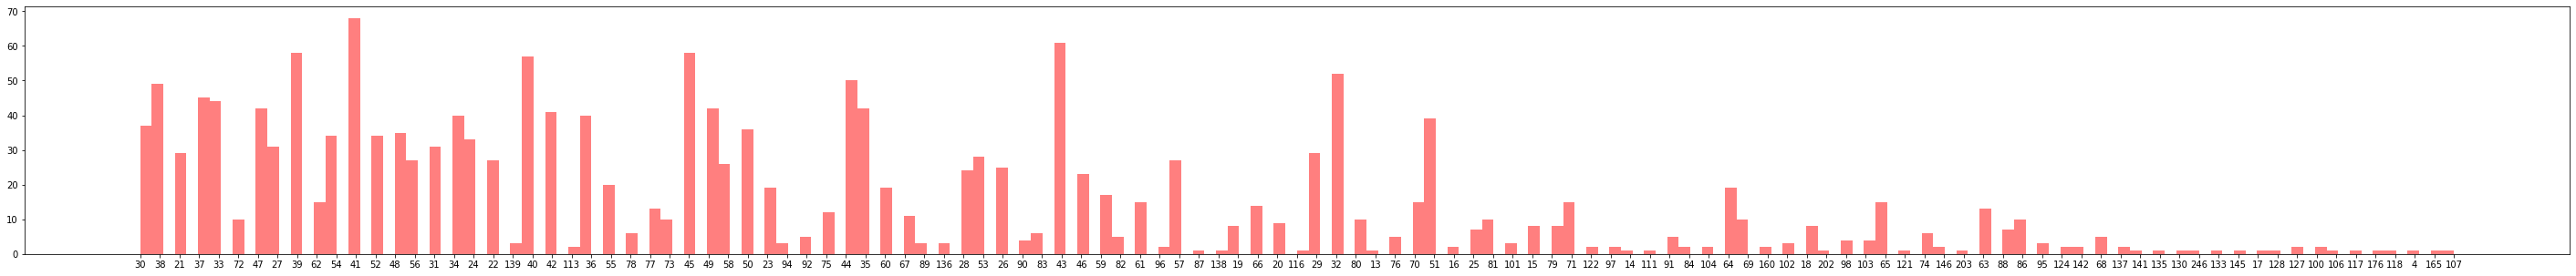

In [0]:
import matplotlib
matplotlib.rc('figure', figsize=[50,5])
#Getting the length of each reply
data["question_length"]= data["question"].str.len()
len_questions = data["question_length"].values

#converting datatype to string
len_str_arr = []
for num in len_questions:
  len_str_arr.append(str(num)) 

no_reply_counter = 0
for num in len_questions:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_questions:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_questions)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_questions)))/(len(list(len_questions))))
print('*' * 50)

print("No of unique reply", end = ' : ')
print(len(list(set(len_questions))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

From the above graph we can observe that we have minimum of <b>4</b> character in the email<br><br>
maximum length of the questions is <b>270</b><br><br>
and we have unique distribution of <b>156</b> questions.

Top Unique distribution of questions in dataset

In [0]:
question_list = list(data['question'].values)
questions_dict = {i:question_list.count(i) for i in question_list}

In [0]:
from collections import OrderedDict
questions_dict_sorted = OrderedDict(sorted(questions_dict.items(), key=lambda x: x[1]))

In [0]:
questions = []
keys = []
for item in questions_dict_sorted.items():
  questions.append(item[0])
  keys.append(item[1])

In [0]:
questions.reverse()
keys.reverse()

In [0]:
#top 10 reply
top_5_questions = questions[:5]
top_5_keys = keys[:5]

In [0]:
temp_questions_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_questions_list.append(top_5_questions[i])
  i += 1

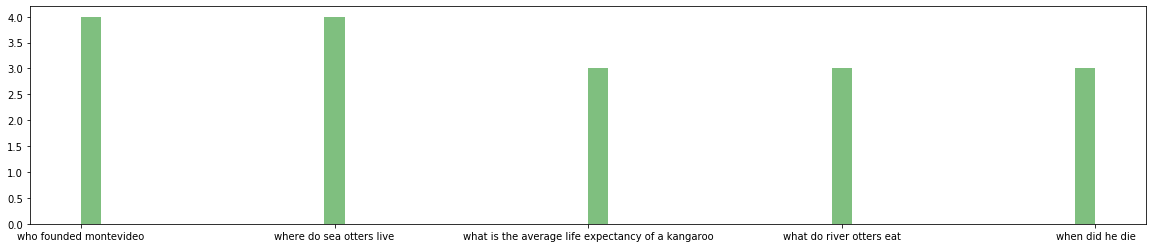

In [0]:
import matplotlib
matplotlib.rc('figure', figsize=[20,4])
plt.hist(temp_questions_list, 50,
         histtype='bar',
         facecolor='g',
         alpha=0.5)
plt.show()

Here we can see the top 5 repeated questions,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; It's not looking usefull for any interpretation

In [0]:
print(data.head(5))
print(data.tail(5))

                                    question  ... question_length
1085          how is the climate in the city  ...              30
579   where is harvesting wild turtles legal  ...              38
2238                   what expired on march  ...              21
693    what are the three segments of an ant  ...              37
2080       who is the head of state of ghana  ...              33

[5 rows x 5 columns]
                                               question  ... question_length
3      what is the battery made by volta credited to be  ...              48
260                 what is the smallest species of fox  ...              35
105   what is the name of a university or similar in...  ...              97
1459  where do most people in urban saint petersburg...  ...              51
1600            what is the official language of turkey  ...              39

[5 rows x 5 columns]


Here we can <b>combine the Article Title with the question</b> which can help in getting better suggestions.

<b>Modelling Approaches:<br><i>
# here before modeling we can stammer the sentences : Playing ko play
* Seq2seq model
* Bi-Directional LSTM
* Attention Layer
* Beam Search</b></i>

# Modeling

In [0]:
# Vocabulary of question
all_email_words=[]
for quest in data.question:
    for word in quest.split():
        if word not in all_email_words:
            all_email_words.append(word)

# Vocabulary of reply 
all_reply_words=[]
for mar in data.reply:
    for word in mar.split():
        if word not in all_reply_words:
            all_reply_words.append(word)

In [0]:
all_email_words = list(set(all_email_words))

In [0]:
all_reply_words = list(set(all_reply_words))

In [0]:
data.head()

,question,reply,reply_length,reply Length,question_length
1085,how is the climate in the city,start_ the city is hot and humid _end,26,37,30
579,where is harvesting wild turtles legal,start_ florida _end,7,19,38
2238,what expired on march,start_ monroe's presidency _end,19,31,21
693,what are the three segments of an ant,"start_ the head, mesosoma and metasoma are the...",69,80,37
2080,who is the head of state of ghana,start_ john agyekum kufuor _end,19,31,33


In [0]:
len("hello")

5

In [0]:
import numpy as np
lenght_list=[]
for l in data.question.values:
    lenght_list.append(len(l.split(' ')))
max_length_src = max(lenght_list)
max_length_src

46

In [0]:
#getting the max length of the list
lenght_list=[]
for l in data.reply.values:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

158

In [0]:

#All input words
input_words = sorted(list(all_email_words))
target_words = sorted(list(all_reply_words))

# get the length of the vocabalary // Kitne words // this will help while performing embedding layer
num_encoder_tokens = len(all_email_words) + 1
num_decoder_tokens = len(all_reply_words) + 1

num_encoder_tokens, num_decoder_tokens

(2889, 3776)

In [0]:
# from word to token we can get
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
input_token_index['three']

2597

In [0]:
# from token to word we can get
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [0]:
# reverse_input_char_index[3940]

In [0]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head(2)

,question,reply,reply_length,reply Length,question_length
1309,how many civilians died in the 1998 us embassy...,start_ over two hundred _end,16,28,54
492,what is the order of santiago,start_ a spanish knightly order _end,24,36,29


In [0]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y = data.question, data.reply
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((1655,), (184,))

In [0]:
y_train.head()

631                                  start_ napoleon _end
2695    start_ in 1990, goh chok tong succeeded lee as...
1100    start_ it lies on a plain, approximately eight...
2727    start_ that his children had been educated wit...
753     start_ yes, the gendarmenmarkt borders the fre...
Name: reply, dtype: object

In [0]:
X_train.head()

631                                who made volta a count
2695    when did goh chok tong succeed lee as prime mi...
1100     what contributes to frequent flooding in jakarta
2727    what was roosevelt's justification for support...
753     does the gendarmenmarkt border the french cath...
Name: question, dtype: object

In [0]:
questions = X.values
replies =  y.values

all_txt_data = questions + replies

In [0]:
all_words = list(set(all_email_words + all_reply_words))
eng_words = list(set(all_email_words))

In [0]:
vocab_len = len(eng_words)
latent_dim = 300

In [0]:
import pickle
glove_pickel = open("drive/My Drive/DonarChoose/glove_vectors","rb")
glove_ = pickle.load(glove_pickel)

In [0]:
vector = glove_.get(word)

In [0]:
embedded_matrix = np.zeros((vocab_len, latent_dim))
for word, i in input_token_index.items():
    vector = glove_.get(word)
    if vector is not None:
      embedded_matrix[i] = vector
print(embedded_matrix.shape)

(2888, 300)


In [0]:
def generate_batch(X, y, batch_size=1):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j+ batch_size], y[j:j + batch_size])):

                # for words in each sentence //question
                for (t, word) in enumerate(input_text.split()):  # question wale text ko tokenize kiya gaya
                    encoder_input_data[i,t] = input_token_index[word]  # encoder input seq

                # for each word in   Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()) -1:
                        decoder_input_data[i,t] = target_token_index[word]  # decoder input seq
                    if t > 0: #>0 cz we have to remove word start_
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t - 1,
                                target_token_index[word]] = 1.
                                                       
            return ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [0]:
#https://stackoverflow.com/questions/56097089/how-to-fix-name-embedding-is-not-defined-in-keras
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate,Embedding,RepeatVector
embedded_layer = Embedding(vocab_len,latent_dim,weights=[embedded_matrix],input_length=1500,trainable=False) # we are using the embedded matrix to get the weights which we initialize randomly in embedded layer

In [0]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Concatenate,TimeDistributed
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

# Encoder
latent_dim = 300 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null

# **num_encoder_tokens** vocabulary size we are having

# enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs) #Embedding layer # this layer will make it 3D
enc_emb = embedded_layer(encoder_inputs)


#training the LSTM on encoder
encoder_lstm = Bidirectional(LSTM(128, return_sequences=True, return_state=True))
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


encoder_states = [state_h, state_c] #output and the cell state

In [0]:
num_decoder_tokens

3776

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
#  Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,)) #Reply's input
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True) 
dec_emb = dec_emb_layer(decoder_inputs) # Reply sikhaye hum Embedding layer ko

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_output, decoder_h, decoder_c = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_states = [decoder_h, decoder_c]

# logits = Dense(num_decoder_tokens, name='logits')(drop_layer)
# logits = Lambda(lambda x: x / temperature, name='Temperature')(logits) # this layer brings the predicted probabilitties near to each other, eg dog and cow prob will be near.


decoder_dense = (Dense(num_decoder_tokens, activation='softmax'))
decoder_outputs = decoder_dense(decoder_output)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1500, 300)    866400      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 1500, 256),  439296      embedding_3[0][0]                
____________________________________________________________________________________________

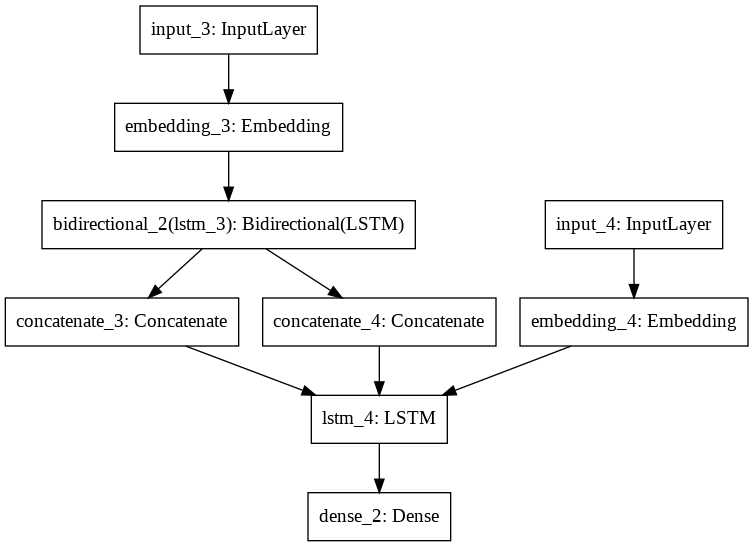

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [0]:
y_train.head()

631                                  start_ napoleon _end
2695    start_ in 1990, goh chok tong succeeded lee as...
1100    start_ it lies on a plain, approximately eight...
2727    start_ that his children had been educated wit...
753     start_ yes, the gendarmenmarkt borders the fre...
Name: reply, dtype: object

In [0]:
#Will Crash if data is very big,because we have given batch size as len(X_train) which will create very big matrix 
enc_dcd_inp_data, decdr_trgt_data = generate_batch(X_train,y_train,batch_size = len(X_train))

In [0]:
model.fit(enc_dcd_inp_data,decdr_trgt_data,batch_size=100,epochs=50,verbose=1) # model.fit is much faster than model.fit_generator function 

Epoch 1/50
1655/1655 [==============================] - 14s 8ms/step - loss: 7.0074 - acc: 0.1299
Epoch 2/50
1655/1655 [==============================] - 12s 7ms/step - loss: 6.3962 - acc: 0.1542
Epoch 3/50
1655/1655 [==============================] - 12s 7ms/step - loss: 6.2579 - acc: 0.1559
Epoch 4/50
1655/1655 [==============================] - 12s 7ms/step - loss: 6.1234 - acc: 0.1562
Epoch 5/50
1655/1655 [==============================] - 12s 7ms/step - loss: 5.9971 - acc: 0.1660
Epoch 6/50
1655/1655 [==============================] - 12s 7ms/step - loss: 5.8673 - acc: 0.1794
Epoch 7/50
1655/1655 [==============================] - 11s 7ms/step - loss: 5.7430 - acc: 0.1837
Epoch 8/50
1655/1655 [==============================] - 12s 7ms/step - loss: 5.6226 - acc: 0.1869
Epoch 9/50
1655/1655 [==============================] - 12s 7ms/step - loss: 5.5110 - acc: 0.1883
Epoch 10/50
1655/1655 [==============================] - 12s 7ms/step - loss: 5.3809 - acc: 0.1917
Epoch 11/50
1655/16

Observation: After removing recurrent yes and no replies trianing accuracy is slowly increasing else it was good and much accurate.

In [0]:
# model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = 50),
#                     steps_per_epoch = 100,
#                     epochs=5,
#                     validation_data = generate_batch(X_test, y_test, batch_size = 50),
#                     validation_steps = 100)

In [0]:
#trying softmax layer with temperature

# def softmax_with_temperature(logits, temperature=1):
#   logits = logits / temperature
#   return np.exp(logits) / np.sum(np.exp(logits))

In [0]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# #  Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None,)) #Reply's input
# dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True) 
# dec_emb = dec_emb_layer(decoder_inputs) # Reply sikhaye hum Embedding layer ko

# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the
# # return states in the training model, but we will use them in inference.


# decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
# decoder_output, decoder_h, decoder_c = decoder_lstm(dec_emb,initial_state=encoder_states)
# decoder_states = [decoder_h, decoder_c]

# logit_layer = Dense(698, name='logits')(decoder_output)

# decoder_dense = TimeDistributed(Dense(num_decoder_tokens, activation='softmax'))
# decoder_outputs = decoder_dense(logit_layer)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
# model_sans_softmax = Model(inputs=model.input, outputs=model.get_layer("logits").output)
# model_logits = model_sans_softmax.predict(a)


In [0]:
# unsoftened_train_prob = softmax_with_temperature(model_logits, 1)

In [0]:
# unsoftened_train_prob.shape

In [0]:
decoder_outputs.shape

# Inference

In [0]:
#Making new model so that we can predict the output
# taking all input and output of the encoder from the previous model to here
    #encoder_inputs: It's the tokenized and padded words from the question
encoder_model = Model(encoder_inputs, encoder_states) # this is not used for the input in the LSTM



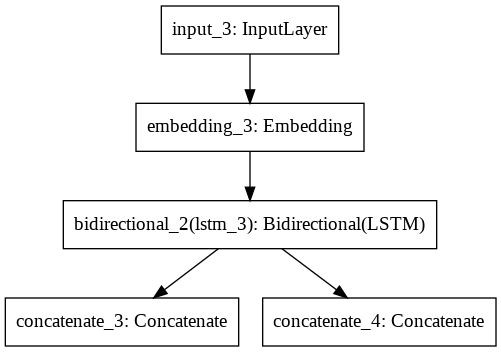

In [0]:
from keras.utils import plot_model
plot_model(encoder_model, to_file='multilayer_perceptron_graph.png')

___

In [0]:
#giving input to decoder
decoder_state_input_h = Input(shape=(256,)) # this will be the input form the encoders # cz 256 is from the encoder after concatination 
decoder_state_input_c = Input(shape=(256,)) #cell state after the encoder

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Reply words tokenized
dec_emb2= dec_emb_layer(decoder_inputs) #Get the embeddings of the decoder sequence

#decoder ka output and cell state nikal liya 
    # decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
        # here dec_emb2 we passed the output from the embedding later which for trained on tokenized sentensed of Reply words
decoder_outputs, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

#added both states from the decoder 
decoder_states = [state_h2, state_c2]  

# Passing the output from the decoder model to the dense layer
decoder_output_dense = decoder_dense(decoder_outputs)




# Final decoder model
# decoder_inputs : Embedding layer ko Reply sentence tokenized
# decoder_states_inputs : this is from the encoder
# decoder_outputs2 : #ye decoder ka output he //predicted values from the decoder not the cellstate or output(h)
# decoder_states2 : #ye output(h) & cell state h from decoder # not form LSTm this is coming after the dense layer


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_output_dense] + decoder_states)

In [0]:
print(decoder_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    1132800     input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

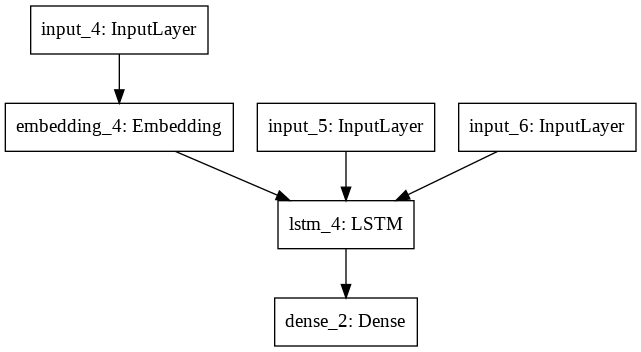

In [0]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='multilayer_perceptron_graph.png')

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) #need to check this logic 
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_end' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
def generate_batch(X, y, batch_size):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j
                    + batch_size], y[j:j + batch_size])):

                # for words in each sentence //question
                for (t, word) in enumerate(input_text.split()):  # question wale text ko tokenize kiya gaya
                    encoder_input_data[i,t] = input_token_index[word]  # encoder input seq

                # for each word in   Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()) - 1:
                        decoder_input_data[i,t] = target_token_index[word]  # decoder input seq
                    if t >=0 :
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t,
                                target_token_index[word]] = 1.
                                                       
            yield ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [0]:
X_test.shape

(184,)

In [0]:
temp_arr = []
for index in range(1,184):
  x =index
  train_gen = generate_batch([X_test.values[x]], [y_test.values[x]], batch_size = 10)

  (input_seq, actual_output), end_temp = next(train_gen)

  predicted_sentence = decode_sequence(input_seq)
  print('question/email: ',X_train.values[x])
  reply = y_train.values[x].replace('start_', '')
  reply = reply.replace('_end','.')
  print('original reply: ',reply)
  predicted_txt = predicted_sentence.replace('_end','.')
  print('predicted reply: ',predicted_txt)
  temp_arr.append(predicted_txt)
  print("\n")
  print("*"*50)
  print("\n")

question/email:  when did goh chok tong succeed lee as prime minister
original reply:   in 1990, goh chok tong succeeded lee as prime minister .
predicted reply:   the three heaviest cats in the world are two are two


**************************************************


question/email:  what contributes to frequent flooding in jakarta
original reply:   it lies on a plain, approximately eight meters above the sea level .
predicted reply:   the reichstag building .


**************************************************


question/email:  what was roosevelt's justification for supporting desegregation of schools in new york
original reply:   that his children had been educated with other races and there was nothing wrong with it .
predicted reply:   the capital of the drum is an western part is the light


**************************************************


question/email:  does the gendarmenmarkt border the french cathedral
original reply:   yes, the gendarmenmarkt borders the french cat

In [0]:
temp_set = list(set(temp_arr))

In [0]:
#number of unique predicitons 
len(temp_set)

168

In [0]:
#All unique predictions
print(temp_set)

[' they otters have problems or wounded .', ' the capital of queen nefertiti is in the altes museum', ' knowledge of 2,000 characters .', ' the leopard of the largest population of montreal is', ' the capital city is the west of montreal is happened', ' the largest primarily french-speaking city of the world,', ' two .', " a flute's can only suppport one littler per year .", ' japan .', ' a oblong shape .', ' because it are small particles called marine snow .', ' he was coulomb was a vegetarian .', ' ursidae .', ' amnoites .', ' 7th century bc .', ' he was too expensive .', ' a "melburnian" .', ' the volt .', " the leopard has rosettes rather than cheetah's simple", ' the largest is held in the largest is in the use of', ' sheep gut .', ' hardin county .', ' by 2001, a ability to pull down prey substantially', ' turtles use have their pounds .', ' the maple leaf flag .', ' yes, a stream of a popular butterfly is an identical', ' because of the language language of the identical part',

In [0]:
#Model is not predicting good reply

In [0]:
#Model is waster here

Conclusion

We used encoder decoder approach to predict the reply.

1. We took the data 
2. Did EDA over it
3. Took only the replies and question whose length is small
4. Tokenized the questions
5. pad the question
6. encoder will take this as an input from embedding layer 
7. encoder is LSTM which passes the vectors to the decoder
8. where decoder takes vector from encoder and words(real words) and get trained
9. For inference we are using same weights from the learning model
10. Used in inferencing encoder and decoder and this time decoder will get only the vectors from encoder 
11. it'll predict the reply till "_end" is predicted
12. we'll de tokenize and will get the predicted reply


</br> </br></br> </br></br> </br>
<center> <h2>How LSTM Works </h2></b> </br></br>
In LSTM 
we pass the input to layer 1 and it recur multiple times , with function time 
LSTM has 3 layers inside it</br> <b>
Input ,output,forget</b>  </br></br>
x and + are there which help me carring the data to further layer (like ResNet Skipping) so that original data can be preserved and if some data model didn' learn can be passed foward so that next time it may learn and can pass data to another layer without the loss 

</br></br>

when we get the input as the output form previous interation or layer and the data as inout the we combine them and pass it throught sigmoid function which will (Ft) which tell how much to remember and forget it goes to (x)

</br></br>

and again now we thanwe take same input to previous sigmoid fucntiona  pass it to sigmoid and tanh and perform binary multiplication of output form sigmoid and tanh ( this tell how much input should impact the output of the layer)

</br> </br>

and the out put from previous layer is binary added to the output line 
</br></br>
the again we put signoid layer which take (WiYt concated with w(Ot-1)) and goes to sigmoid layer and binary multiplied with the tanh of the ooutput line and give output as Yit which passes to another layer or to same with new iteration
</br></br>



Reference taken from https://cs224d.stanford.edu/reports/ZhouXu.pdf </center>



in above models we tried multiple LSTM layers and neurons to train it better and get best output